In [1]:
import numpy as np
from pandas import read_pickle
import sklearn.cluster
import time
from wikiparse import pipeline_utils as utils

In [2]:
from pathlib import Path
scratch_folder = Path("scratch-pipeline")

In [3]:
import time
pipeline_start = time.time()

In [4]:
gdf = read_pickle(scratch_folder/'gdf.pkl')

In [5]:
gdf['lon'] = gdf.geometry.map(lambda p: p.x)
gdf['lat'] = gdf.geometry.map(lambda p: p.y)
gdf.drop(gdf[gdf.lat > 90].index, inplace=True)
gdf.drop(gdf[gdf.lon > 180].index, inplace=True)
gdf.drop(gdf[gdf.lon < -180].index, inplace=True)
gdf.lat.min(), gdf.lat.max(), gdf.lon.min(), gdf.lon.max()

(-84.08333333333333, 80.0534072, -179.3567, 166.16666666666666)

In [6]:
partial_fit_size = min(len(gdf), 100_000)
batch_size = 100

for n_clusters in [193, 2000, 10_000]:
    start = time.time()
    # Convert DataFrame to matrix
    mat = gdf[['lat', 'lon']].values
    # Using sklearn
    km = sklearn.cluster.MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size)
    print("created model for", n_clusters)
    km = km.partial_fit(mat[np.random.choice(mat.shape[0], partial_fit_size, replace=False), :])
    km = km.partial_fit(mat[np.random.choice(mat.shape[0], partial_fit_size, replace=False), :])
    km = km.partial_fit(mat[np.random.choice(mat.shape[0], partial_fit_size, replace=False), :])

    # Format results as a DataFrame
    print(n_clusters, 'learning took', round((time.time()-start)/60, 1), 'minutes')
    
    start = time.time()
    labels = km.predict(mat)
    gdf['cluster_' + str(n_clusters)] = labels
    print('predicting took', round((time.time()-start)/60, 1), 'minutes')

created model for 193
193 learning took 0.1 minutes
predicting took 0.0 minutes
created model for 2000
2000 learning took 0.7 minutes
predicting took 0.0 minutes
created model for 10000
10000 learning took 3.4 minutes
predicting took 0.1 minutes


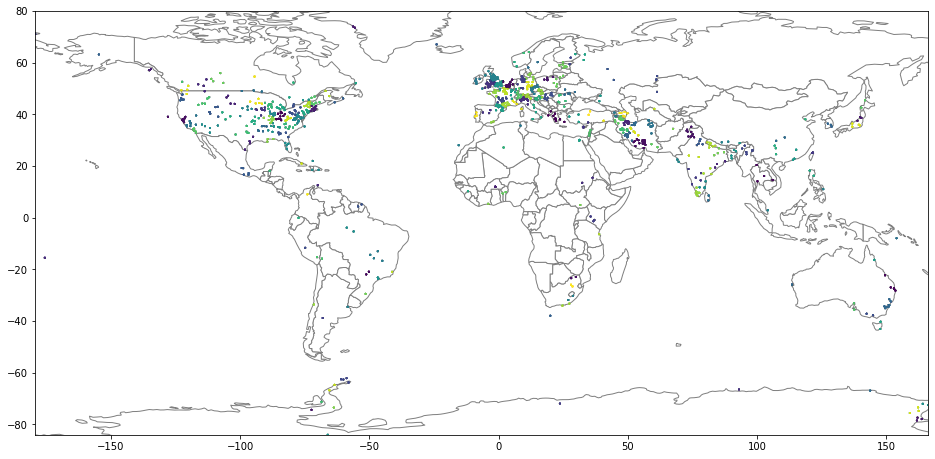

In [7]:
sample_gdf = gdf.sample(partial_fit_size)
utils.map_gdf(sample_gdf, c=sample_gdf.cluster_193, fname=scratch_folder/'clusters_193.png')

In [8]:
gdf.to_pickle(scratch_folder/'gdf_clusters.pkl')

In [9]:
took = time.time() - pipeline_start
if took < 60:
    print("pipeline took", round(took, 2), "seconds")
elif took < 3600:
    print("pipeline took", round(took/60, 2), "minutes")
else:
    print("pipeline took", round(took/60/60, 2), "hours")

pipeline took 4.43 minutes
